# 1. Import Data dan Library
Pada tahap pertama ini saya menambahkan library-library yang kemungkinan akan saya perlukan untuk melakukan proses selanjutnya. dan saya juga meng-upload dataset yang akan saya gunakan

In [64]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import log

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, learning_curve, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from time import time

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [65]:
df = pd.read_csv('Fish.csv')
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


Disini saya berhasil mengupload dan membaca dataset yang saya perlukan

# 2. EXPLORATORY DATA ANALYSIS
Dalam tahapan ini saya akan melakukan visualisasi dan mendeteksi apakah dalam dataset saya terdapat outlier, sehingga dapat memudahkan saya dalam tahapan Pre-Processing

In [66]:
df.info

<bound method DataFrame.info of     Species  Weight  Length1  Length2  Length3   Height   Width
0     Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1     Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2     Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3     Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4     Bream   430.0     26.5     29.0     34.0  12.4440  5.1340
..      ...     ...      ...      ...      ...      ...     ...
154   Smelt    12.2     11.5     12.2     13.4   2.0904  1.3936
155   Smelt    13.4     11.7     12.4     13.5   2.4300  1.2690
156   Smelt    12.2     12.1     13.0     13.8   2.2770  1.2558
157   Smelt    19.7     13.2     14.3     15.2   2.8728  2.0672
158   Smelt    19.9     13.8     15.0     16.2   2.9322  1.8792

[159 rows x 7 columns]>

In [67]:
df.isnull().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

Kode diatas digunakan untuk mengecek apakah dalam dataset kita terdapat nilai kosong atau Null. Dan setelah saya cek ternyata di dataset saya tidak terdapat nilai kosong

In [68]:
df.Species.unique()

array(['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt'],
      dtype=object)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



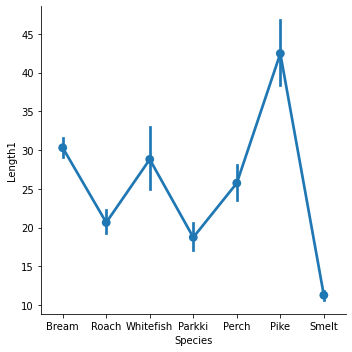


Max length of fish: 59.0
Min length of fish: 7.5
Average length of fish: 26.24716981132075



In [69]:
sns.factorplot('Species','Length1',data=df)
plt.show()
print('')
print('Max length of fish:',df['Length1'].max())
print('Min length of fish:',df['Length1'].min())
print('Average length of fish:',df['Length1'].mean())
print('')

Dapat dilihat bahwa maximum panjang dari ikan yaitu 53,17, Minimum 7,5, dan rata-rata panjang ikan yaitu 26,17

Text(0.5, 0, 'diagonal width in cm')

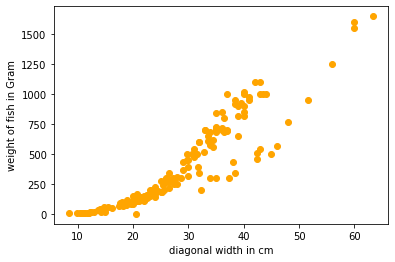

In [70]:
y = df.Weight.values.reshape(-1,1)
x = df.Length2.values.reshape(-1,1)

plt.scatter(x,y,color='orange')
plt.ylabel("weight of fish in Gram")
plt.xlabel("diagonal width in cm")

Diatas merupakan scatter plot dari dataset fish market berdasarkan panjang dan berat ikan

# 3. PRE-PROCESSING
Pada tahapan pre processing ini saya akan mencoba untuk menghilangkan outlier pada kolom Weight, Length1, Length2, dan Length3 dengan menggantikan outlier value atau nilai outlier dengan menggunakan metode IQR

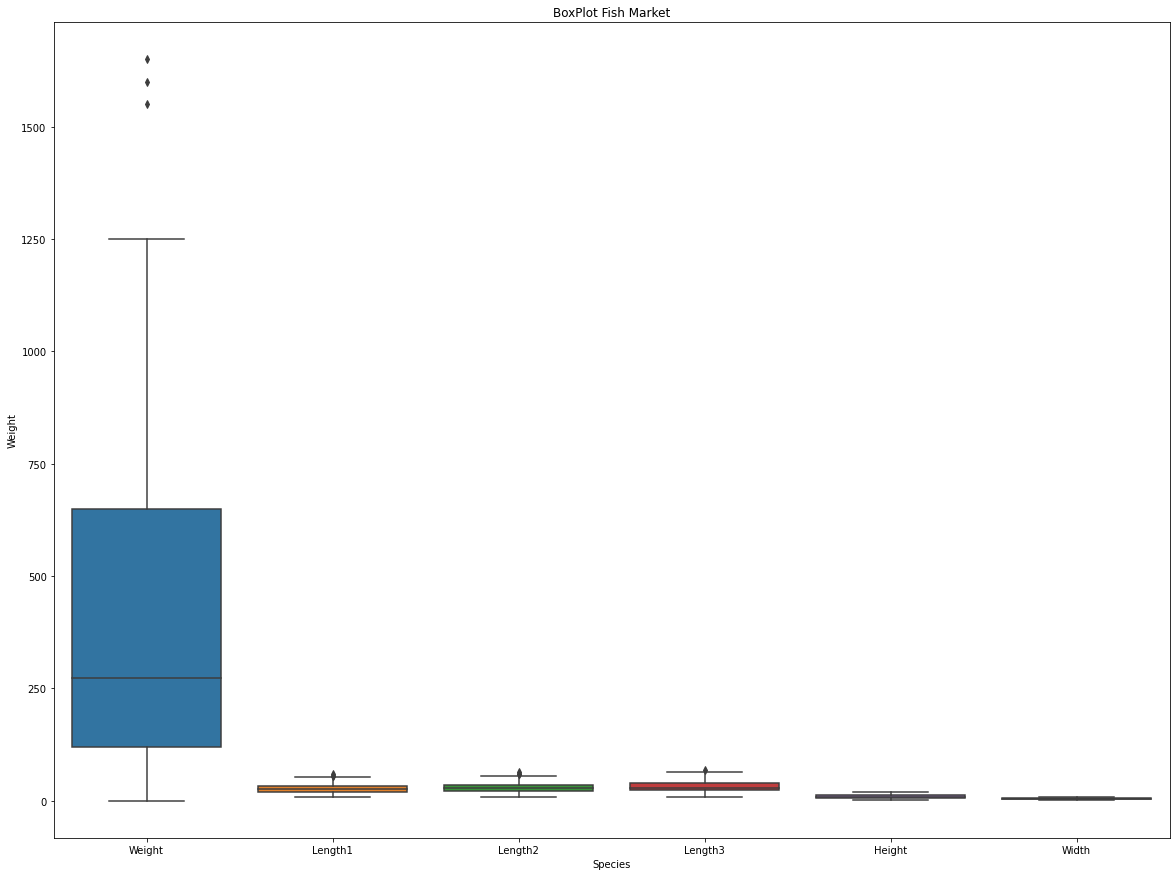

In [71]:
plt.figure(figsize=(20, 15))
sns.boxplot(data=df.iloc[:, :10], orient="z")

plt.title("BoxPlot Fish Market")
plt.xlabel('Species')
plt.ylabel('Weight')

plt.show()

Setelah di visualisasi menggunakan boxplot terdapat outlier di kolom Weight, Length1, Length2, dan Length3

In [72]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_range = Q1 - (1.5*IQR)
    upper_range = Q3 + (1.5*IQR)
    return lower_range, upper_range

Dari kode di atas, saya membuat sebuah fungsi, yaitu remove outlier, yang akan menerima sebuah argumen berupa nama dari kolom. Kemudian akan ditentukan nilai lower dan upper range dari data tersebut.



In [73]:
LowFish, UpperFish = remove_outlier(df['Weight'])
df['Weight'] = np.where(df['Weight']>UpperFish,UpperFish,df['Weight'])
df['Weight'] = np.where(df['Weight']<LowFish,UpperFish,df['Weight'])
LowFish, UpperFish = remove_outlier(df['Length1'])
df['Length1'] = np.where(df['Length1']>UpperFish,UpperFish,df['Length1'])
df['Length1'] = np.where(df['Length1']<LowFish,UpperFish,df['Length1'])
LowFish, UpperFish = remove_outlier(df['Length2'])
df['Length2'] = np.where(df['Length2']>UpperFish,UpperFish,df['Length2'])
df['Length2'] = np.where(df['Length2']<LowFish,UpperFish,df['Length2'])
LowFish, UpperFish = remove_outlier(df['Length3'])
df['Length3'] = np.where(df['Length3']>UpperFish,UpperFish,df['Length3'])
df['Length3'] = np.where(df['Length3']<LowFish,UpperFish,df['Length3'])


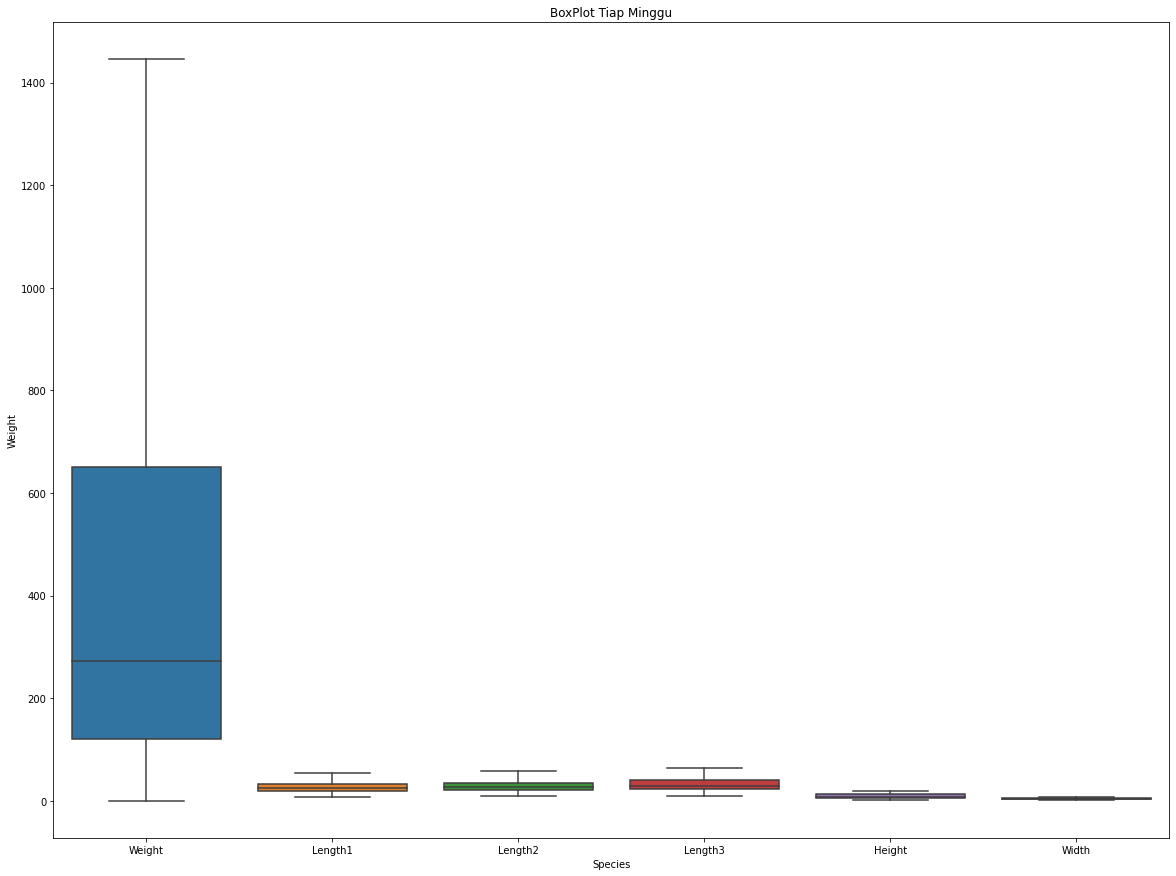

In [74]:
plt.figure(figsize=(20, 15))
sns.boxplot(data=df.iloc[:, :10], orient="z")

plt.title("BoxPlot Tiap Minggu")
plt.xlabel('Species')
plt.ylabel('Weight')

plt.show()

Berikut adalah tampilan boxplot setelah saya melakukan removing outlier sehingga tidak terdapat kolom yang memiliki nilai di atas batas maksimum dan dapat dikatan saya telah berhasil untuk menghilangkan outlier tersebut di setiap kolomnya

# 4. LINEAR REGRESSION

In [75]:
# Encoding
species_encoded = pd.get_dummies(df['Species'])
label = df['Weight']
features = df.drop(columns=['Species', 'Weight'])

print('=== Species Encoded ===')
display(species_encoded.head(3))
print('')
print('=== Label ===')
display(label.head(3))
print('')
print('=== Features ===')
display(features.head(3))

=== Species Encoded ===


,Bream,Parkki,Perch,Pike,Roach,Smelt,Whitefish
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0



=== Label ===


0    242.0
1    290.0
2    340.0
Name: Weight, dtype: float64


=== Features ===


,Length1,Length2,Length3,Height,Width
0,23.2,25.4,30.0,11.5200,4.0200
1,24.0,26.3,31.2,12.4800,4.3056
2,23.9,26.5,31.1,12.3778,4.6961


Disini saya menggunakan metode encoding untuk merepresentasikan data bertipe kategori sebagai vektor biner yang bernilai integer, 0 dan 1, dimana semua elemen akan bernilai 0 kecuali satu elemen yang bernilai 1, yaitu elemen yang memiliki nilai kategori tersebut.

In [76]:
# Feature Scalling -> Robust Scaller
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
rs_scaller = MinMaxScaler()
columns_name = features.columns.values

features = rs_scaller.fit_transform(features)
features = pd.DataFrame(data=features, columns=columns_name)
features.head()

,Length1,Length2,Length3,Height,Width
0,0.343733,0.348004,0.381295,0.568334,0.418978
1,0.361248,0.366428,0.402878,0.624055,0.459235
2,0.359059,0.370522,0.401079,0.618123,0.514279
3,0.411604,0.421699,0.444245,0.638566,0.480365
4,0.415982,0.421699,0.453237,0.621966,0.576004


Kode diatas merupakan fungsi scalling dengan menggunakan metode robust scaler. Fungsi dari scalling ini untuk mengurangi range value biar output data nya tidak terlalu jauh. Disini saya mencoba menggunakan metode Robust Scaler karena metode ini tidak terpengaruh oleh outlier. Namun jika tidak terdapat outlier dapat menggunakan metode MinMax dan StandardScaler

In [77]:
X = pd.merge(features, species_encoded, left_index=True, right_index=True)
X.head(10)

,Length1,Length2,Length3,Height,Width,Bream,Parkki,Perch,Pike,Roach,Smelt,Whitefish
0,0.343733,0.348004,0.381295,0.568334,0.418978,1,0,0,0,0,0,0
1,0.361248,0.366428,0.402878,0.624055,0.459235,1,0,0,0,0,0,0
2,0.359059,0.370522,0.401079,0.618123,0.514279,1,0,0,0,0,0,0
3,0.411604,0.421699,0.444245,0.638566,0.480365,1,0,0,0,0,0,0
4,0.415982,0.421699,0.453237,0.621966,0.576004,1,0,0,0,0,0,0
5,0.422551,0.436029,0.465827,0.689203,0.546882,1,0,0,0,0,0,0
6,0.422551,0.436029,0.462230,0.722699,0.596372,1,0,0,0,0,0,0
7,0.440066,0.442170,0.471223,0.635084,0.513419,1,0,0,0,0,0,0
8,0.440066,0.442170,0.473022,0.712565,0.535098,1,0,0,0,0,0,0
9,0.459770,0.456499,0.492806,0.725433,0.551393,1,0,0,0,0,0,0


Berikut adalah tampilan dari dataset saya setelah di scalling dan di encoding

In [78]:
# Dependant (Target) Variable:
y = df['Weight']
# Independant Variables:
X = df.iloc[:,2:7]
# X=df.drop['Weight','Species']

Disini saya akan menyiapkan model machine learing

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Kode diatas digunakan untuk membagi dataset menjadi "Train" dan "Test" Dataset

In [80]:
y

0      242.0
1      290.0
2      340.0
3      363.0
4      430.0
       ...  
154     12.2
155     13.4
156     12.2
157     19.7
158     19.9
Name: Weight, Length: 159, dtype: float64

In [81]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

Kode diatas merupakan Sklearn Library Linear Regression Model

In [82]:
y_pred = reg.predict(X_test)

Disini saya menggunakan model Train dan Test Dataset untuk memperkirakan berat ikan 

In [83]:
reg.score(X_test, y_test)

0.8671328429734948

Disini saya Menganalisis Keberhasilan Model Train dari Dataset test dan Prediksi

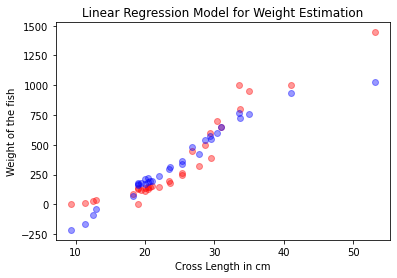

In [84]:
plt.scatter(X_test['Length1'], y_test, color='red', alpha=0.4)
plt.scatter(X_test['Length1'], y_pred, color='blue', alpha=0.4)
plt.xlabel('Cross Length in cm')
plt.ylabel('Weight of the fish')
plt.title('Linear Regression Model for Weight Estimation');

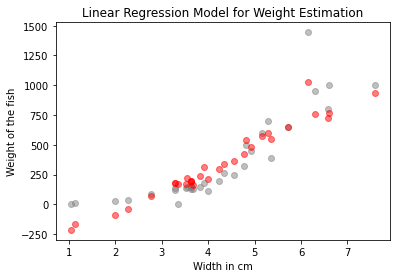

In [85]:
plt.scatter(X_test['Width'], y_test, color='gray', alpha=0.5)
plt.scatter(X_test['Width'], y_pred, color='red', alpha=0.5)
plt.xlabel('Width in cm')
plt.ylabel('Weight of the fish')
plt.title('Linear Regression Model for Weight Estimation');

# 5. LOGISTIC REGRESSION
Saya akan menggunakan Regresi Logistik untuk klasifikasi, dan selanjutnya memprediksi jenis ikan berdasarkan berat, tinggi dan lebarnya.


In [88]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import plotly.express as px

In [89]:
px.scatter(df,x='Height',y='Length1',size='Weight',color='Species')

Dari hasil analisis menyeluruh dapat melihat bahwa berat ikan tidak terpengaruh oleh spesiesnya tetapi memiliki nilai yang berbeda. Namun, spesies seperti Smelt dan Bream memiliki distribusi bobot yang rata-rata.

In [90]:
X=df.loc[:,'Weight':'Width']
y=df['Species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [91]:
print('Dimenstions of Train Set of features:',np.shape(X_train))
print('Dimensions of Train Set of the target:',np.shape(y_train))
print('Dimenstions of Test Set of features:',np.shape(X_test))
print('Dimenstions of Test Set of the target:',np.shape(y_test))

Dimenstions of Train Set of features: (111, 6)
Dimensions of Train Set of the target: (111,)
Dimenstions of Test Set of features: (48, 6)
Dimenstions of Test Set of the target: (48,)


In [92]:
logreg=LogisticRegression(max_iter=100000).fit(X_train,y_train)

Disini saya akan menggunakan nilai default untuk Logistic Regression

In [93]:
print('Model intercept: ', logreg.intercept_)
print('Model coefficients: ',logreg.coef_)

Model intercept:  [-18.3544325   10.73796824  12.10573016 -21.44480039   2.83062182
  12.20904591   1.91586676]
Model coefficients:  [[ 0.00688137 -0.54584641 -0.33782895  0.98562312  1.52265022 -0.17903612]
 [ 0.01945984 -0.08027155 -0.23880844 -0.60376729  1.5652002  -0.14815723]
 [ 0.02785054  0.4260157   1.59858156 -2.12604491 -0.80452384  0.32793568]
 [-0.00260566  0.30024904  0.31511703  0.45655423 -0.65454155 -0.21539026]
 [ 0.00251326  0.02256282 -1.28263898  1.25721841 -0.32825443  0.37222861]
 [-0.07810251  0.33514352  0.02355818 -0.14952503 -1.50278813 -0.60130505]
 [ 0.02400317 -0.45785313 -0.0779804   0.17994147  0.20225751  0.44372438]]


In [94]:
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.973
Test set score: 0.938


Dapat dilihat saya mendapatkan Train score 0.973 dan Test score 0.938. Dapat dikatakan model saya berjalan dengan baik

In [95]:
from sklearn.metrics import classification_report,confusion_matrix

In [96]:
pred1=logreg.predict(X_test)
print(confusion_matrix(y_test,pred1))
print('\n')
print(classification_report(y_test,pred1))

[[13  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0]
 [ 0  0 14  0  0  0  0]
 [ 0  0  0  5  0  0  0]
 [ 0  0  0  0  4  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  1  0  2  0  0]]


              precision    recall  f1-score   support

       Bream       1.00      1.00      1.00        13
      Parkki       1.00      1.00      1.00         3
       Perch       0.93      1.00      0.97        14
        Pike       1.00      1.00      1.00         5
       Roach       0.67      1.00      0.80         4
       Smelt       1.00      1.00      1.00         6
   Whitefish       0.00      0.00      0.00         3

    accuracy                           0.94        48
   macro avg       0.80      0.86      0.82        48
weighted avg       0.89      0.94      0.91        48



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [97]:
logreg.predict([[400,26.0,30.0,37.0,12.3,5.0]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



array(['Bream'], dtype=object)

Meskipun dataset yang saya gunakan cukup kecil, tetapi model yang telah saya buat dapat menghasilkan skor yang sangat baik yaitu dengan skor train: 0,973 dan test skor: 0,938. Jika saya memiliki jumlah spesies yang terdistribusi secara merata dalam kumpulan data yang saya punya, maka kemungkinan untuk 'menebak' yang benar adalah 1/7. Sebaliknya, jika saya memiliki nilai spesies yang berbeda, maka total terdiri dari 159 spesies. Jadi untuk menebak probabilitas 'perch' adalah 56/159, dan spesies lain 35/159, 20/159, 17/159,14/159, 11/159 dan 6/159. Jumlah spesies yang cukup kecil untuk memiliki demonstrasi Regresi Logistik yang akurat. Selain itu, memiliki beberapa fitur khusus seperti berat, panjang, dll., kemungkinan untuk menemukan jenis yang akurat akan meningkat secara signifikan. Salah satu cara untuk menunjukkan potensi tinggi adalah memiliki jumlah spesies yang lebih banyak.